In [ ]:
!pip install -q tensorflow==2.1

     |████████████████████████████████| 421.8MB 41kB/s 
     |████████████████████████████████| 3.9MB 46.9MB/s 
     |████████████████████████████████| 450kB 48.9MB/s 


In [ ]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

print(tf.__version__)

2.1.0


In [ ]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla P4 (UUID: GPU-e08b1aed-27fd-2125-01ee-3de71eff5d26)


## Load and preprocess MNIST dataset

In [ ]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28*28).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28*28).astype(np.float32) / 255.

print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784) float32
(10000, 784) float32


## Draw MNIST examples

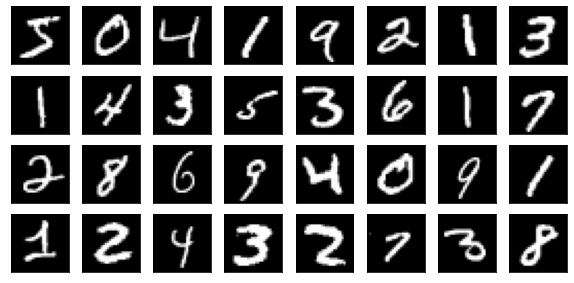

In [ ]:
def plot_digits(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow(samples[j, ...].reshape(28, 28), cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_digits(train_x[:32, ...])

## Create VAE parts: Encoder and Decoder

In [ ]:
class Encoder(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.fc1 = L.Dense(512, activation='relu')
        self.fc2 = L.Dense(2, activation=None)
        self.fc3 = L.Dense(2, activation=None)
        
    def call(self, inp):
        h = self.fc1(inp)
        z_mean = self.fc2(h)
        z_log_sigma = self.fc3(h)
        batch_size = inp.shape[0]
        rnd = tf.random.normal(tf.shape(z_mean))
        z = z_mean + tf.exp(z_log_sigma) * rnd
        return z_mean, z_log_sigma, z

class Decoder(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.fc1 = L.Dense(512, activation='relu')
        self.fc2 = L.Dense(784, activation='sigmoid')
        
    def call(self, inp):
        h = self.fc1(inp)
        out = self.fc2(h)
        return out

encoder = Encoder()
decoder = Decoder()

## VAE inference and loss functions

In [ ]:
def vae(inp):
    _, _, z = encoder.predict(inp)
    out = decoder.predict(z)
    return out

def vae_loss(inp, target):
        z_mean, z_log_sigma, z = encoder(inp)
        pred = decoder(z)
        
        mse_loss = tf.reduce_sum(tf.square(pred - target), axis=1)
        tmp = 1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma)
        KL_loss = -0.5 * tf.reduce_sum(tmp, axis=-1)
        return tf.reduce_mean(mse_loss + KL_loss)

## Training parameters, dataset pipeline, optimizer

In [ ]:
NUM_EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = 0.001

train_ds = tf.data.Dataset.from_tensor_slices(train_x)
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)

## VAE training

In [ ]:
for e in range(NUM_EPOCHS):
    for batch in train_ds:    
        with tf.GradientTape() as tape:
            loss_value = vae_loss(batch, batch)
        train_vars = encoder.variables + decoder.variables
        grads = tape.gradient(loss_value, train_vars)
        optimizer.apply_gradients(zip(grads, train_vars))

    print("[Epoch %2d] Train Loss: %.4f" % (e, loss_value.numpy()))

[Epoch  0] Train Loss: 42.0482
[Epoch  1] Train Loss: 41.2166
[Epoch  2] Train Loss: 41.3137
[Epoch  3] Train Loss: 39.6474
[Epoch  4] Train Loss: 37.8306
[Epoch  5] Train Loss: 39.4427
[Epoch  6] Train Loss: 37.7108
[Epoch  7] Train Loss: 37.3888
[Epoch  8] Train Loss: 36.9406
[Epoch  9] Train Loss: 37.7851
[Epoch 10] Train Loss: 38.6232
[Epoch 11] Train Loss: 37.8799
[Epoch 12] Train Loss: 37.3421
[Epoch 13] Train Loss: 37.9688
[Epoch 14] Train Loss: 37.3099
[Epoch 15] Train Loss: 35.6411
[Epoch 16] Train Loss: 34.5176
[Epoch 17] Train Loss: 38.1158
[Epoch 18] Train Loss: 34.7886
[Epoch 19] Train Loss: 37.4234
[Epoch 20] Train Loss: 34.6557
[Epoch 21] Train Loss: 36.4506
[Epoch 22] Train Loss: 35.6529
[Epoch 23] Train Loss: 37.4589
[Epoch 24] Train Loss: 33.7492


## VAE inference test

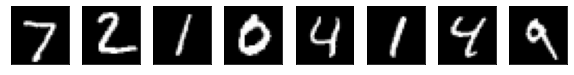

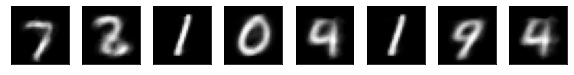

In [ ]:
text_x_pred = vae(test_x[0:8])

plot_digits(test_x[0:8])
plot_digits(text_x_pred)

## VAE generation test

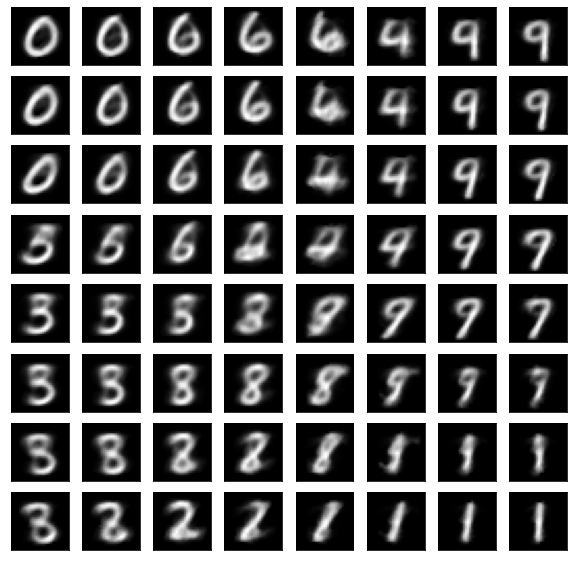

In [ ]:
generated_list = []

for xi in np.linspace(-1, 1, 8):
    for xj in np.linspace(-1, 1, 8):
        generated = decoder.predict(np.array([[xi, xj]]))
        generated_list.append(generated)

plot_digits(np.concatenate(generated_list))

## VAE encoded distribution visualization

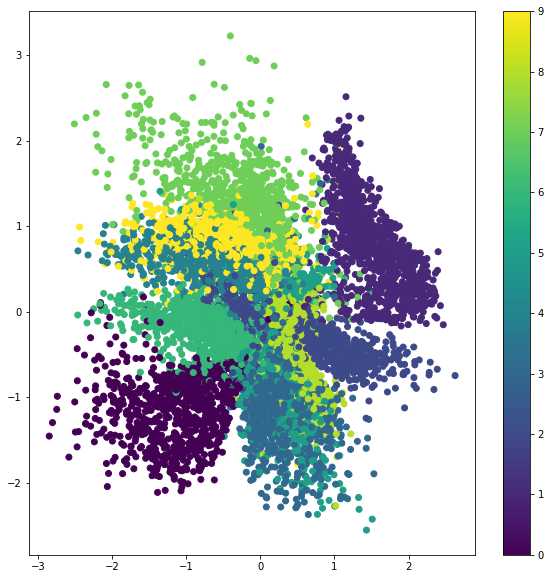

In [ ]:
test_x_enc = encoder.predict(test_x)[0]
plt.figure(figsize=(10, 10))
plt.scatter(test_x_enc[:, 0], test_x_enc[:, 1], c=test_y)
plt.colorbar()
plt.show()

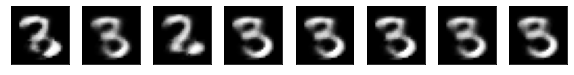

In [ ]:
plot_digits(decoder.predict(np.random.rand(8, 2) + np.array([[1, -2]])))